# Natural Language Processing: Detecting Humor
## TP2 - IART - G44
- [Afonso Caiado, up201806789](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806789)
- [Diogo Nunes, up201808546](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201808546)
- [João Pinto, up201806667](https://sigarra.up.pt/feup/pt/fest_geral.cursos_list?pv_num_unico=201806667)

**It is recommended to [view this notebook in nbviewer](http://nbviewer.ipython.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) for the best viewing experience.**

**You can also [execute the code in this notebook on Binder](https://mybinder.org/v2/gh/rhiever/Data-Analysis-and-Machine-Learning-Projects/master?filepath=example-data-science-notebook%2FExample%20Machine%20Learning%20Notebook.ipynb) - no local installation required.**

## Table of contents

1. [Introduction](#Introduction)
2. [Required libraries](#Required-libraries)
3. [Checking the data](#Checking-the-data)
4. [Preprocessing the data](#Preprocessing-the-data)
    - [Porter Stemming](#Porter-Stemming)
    - [Snowball Stemming](#Snowball-Stemming)
    - [Lancaster Stemming](#Lancaster-Stemming)
    - [Lemmatization](#Lemmatization)
    - [Bag of words Model](#Bag-of-words-Model)
    - [Stemming or Lemmatization?](#Stemming-or-Lemmatization?)
5. [Machine learning algorithms](#Machine-learning-algorithms)
6. [Running the algorithms](#Running-the-algoritms)
7. [Conclusions](#Conclusions)
8. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Humor poses interesting linguistic challenges to NLP, due to its emphasis on multiple word senses, cultural knowledge, and pragmatic competence. Humor appreciation is also a highly subjective phenomenon, and each person can have a different perception of a joke. 

- Is the intention of the text do be humorous? (0 or 1). The first task, is a binary one. We simply have to predict if the text is considered humorous.  
- (If it is intended to be humorous) How humorous do you find it? (1 to 5). In this step, by emulating previous humor detection tasks with ratings and classification scores, we have to predict how humorous the text actually is (if it is humorous).

## Required libraries and imports

[[ go back to the top ]](#Table-of-contents)

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn
    
    conda install -c conda-forge watermark

`conda` may ask you to update some of them if you don't have the most recent version. Allow it to do so.

**Note:** We will not be providing support for people trying to run this notebook outside of the Anaconda Python distribution.

In [ ]:
import time
import pandas as pd
import seaborn as sb
import re
import nltk
import numpy as np

from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import mean_squared_error

## Checking the data

[[ go back to the top ]](#Table-of-contents)

In this section, we will import the dataset needed, check and analyse their content.

In [ ]:
fields = ['id', 'text', 'is_humor', 'humor_rating']
# for this project, we don't need 'humor_controversy' and 'offense_rating'

# Importing the datasets
train = pd.read_csv('datasets/train.csv', usecols=fields, na_values=['NaN'])
train['humor_rating'] = train['humor_rating'].fillna(0)
trainC = pd.DataFrame(train, columns=['id', 'text', 'is_humor'])
trainR = pd.DataFrame(train, columns=['id', 'text', 'humor_rating'])
#trainR['humor_rating'] = trainR['humor_rating'].astype(int)

In [95]:
# Train dataset head
train.head()

,id,text,is_humor,humor_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42
1,2,A man inserted an advertisement in the classif...,1,2.50
2,3,How many men does it take to open a can of bee...,1,1.95
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78


In [96]:
# Train dataset information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8000 non-null   int64  
 1   text          8000 non-null   object 
 2   is_humor      8000 non-null   int64  
 3   humor_rating  8000 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 250.1+ KB


As we can see, our train dataset has 4 relevant fields (for this project):
- **id**
- **text**
- **is_humor**
- **humor_rating**.

In [97]:
# Train dataset statistics
train.describe()

,id,is_humor,humor_rating
count,8000.00000,8000.000000,8000.000000
mean,4000.50000,0.616500,1.393614
std,2309.54541,0.486269,1.185941
min,1.00000,0.000000,0.000000
25%,2000.75000,0.000000,0.000000
50%,4000.50000,1.000000,1.760000
75%,6000.25000,1.000000,2.420000
max,8000.00000,1.000000,4.000000


This table shows that our train dataset has:
- 8000 data lines;
- Curiously, there is no text evaluated with more than 4 in humor_rating column;
- The mean value of humor_rating is 2.26
- 61.6% of the dataset is considered humoristic.

<AxesSubplot:xlabel='is_humor', ylabel='count'>

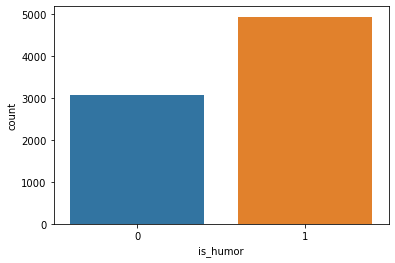

In [98]:
sb.countplot(x='is_humor', data=train)

<AxesSubplot:xlabel='humor_rating', ylabel='count'>

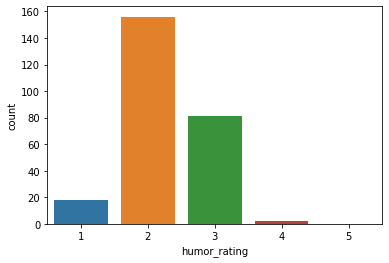

In [99]:
sb.countplot(x='humor_rating', order=[1,2,3,4,5], data=train)

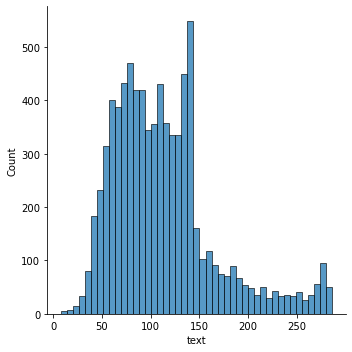

In [100]:
train_len = train['text'].apply(len)
sb.displot(train_len)

## Preprocessing the data

[[ go back to the top ]](#Table-of-contents)

Now, we will do some tasks needed before applying machine learning algorithms:
1. Clean the 'text' column, by removing non-alphanumeric characters;
2. Lowercase and tokenize it;
3. Stem and remove all stopwords;
4. Create bag-of-words model.

For that, we will present 3 stemming techniques and lemmatization.

### Porter Stemming

This preprocessing technique is known as one of the simplest and fastest, commonly used in Information Retrieval systems research, where the experiments need to be exactly repeatable.

In [101]:
def porterStemming(dataset):
    corpus = []
    ps = PorterStemmer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ps.stem(w) for w in text if not w in set(stopwords.words('english'))])
        corpus.append(text)
    
    return corpus

### Snowball Stemming

This technique can support other languages, that's why it's called a multi-lingual stemmer. This stemmer is based on a programming language called ‘Snowball’ that processes small strings and is the most widely used stemmer. The Snowball stemmer is way more aggressive than Porter Stemmer and is also referred to as Porter2 Stemmer. Because of the improvements added when compared to the Porter Stemmer, the Snowball stemmer is having greater computational speed. 

In [102]:
def snowballStemming(dataset):
    corpus = []
    ss = SnowballStemmer(language='english')

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ss.stem(w) for w in text if not w in set(stopwords.words('english'))])
        corpus.append(text)

    return corpus

### Lancaster Stemming

The Lancaster stemmers are more aggressive and dynamic compared to the other two stemmers. The stemmer is really faster, but the algorithm is really confusing when dealing with small words. But they are not as efficient as Snowball Stemmers. The Lancaster stemmers save the rules externally and basically uses an iterative algorithm. 

In [103]:
def lancasterStemming(dataset):
    corpus = []
    ls = LancasterStemmer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([ls.stem(w) for w in text if not w in set(stopwords.words('english'))])
        corpus.append(text)
        
    return corpus

### Lemmatization

> Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [104]:
def lemmatization(dataset):
    corpus = []
    wnl = WordNetLemmatizer()

    for i in range(0, dataset.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
        text = text.lower().split()
        text = ' '.join([wnl.lemmatize(w) for w in text if not w in set(stopwords.words('english'))])

        corpus.append(text)

    return corpus

### Stemming or Lemmatization?

One thing to note about lemmatization is that it is harder to create a lemmatizer in a new language than if it is a stemming algorithm because we require a lot more knowledge about structure of a language in lemmatizers.

Stemming and Lemmatization both generate the foundation sort of the inflected words and therefore the only difference is that stem may not be an actual word whereas, lemma is an actual language word.

Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used a corpus also to supply lemma which makes it slower than stemming. you furthermore might had to define a parts-of-speech to get the proper lemma.

This means that:
- **If speed is key, then stemming should be used**, since lemmatizers scan a corpus which consumes time and processing;
- **If you have time and want even better results, then lemmatizing should be used**.

In [105]:
def dataSplit(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

### Bag of words Model

In [106]:
def bagOfWords(corpus, dataset):
    vectorizer = CountVectorizer(max_features = 1500)
    x = vectorizer.fit_transform(corpus).toarray()
    y = dataset.iloc[:,-1].values
    return x, y

## Applying machine learning algorithms

[[ go back to the top ]](#Table-of-contents)

We implemented these 3 machine learning algorithms:
- **Naïve Bayes**: Gaussian
- **Decision Trees**: Classifier
- **SVM**


In [107]:
def naiveBayes(X_train, y_train, X_test):
    classifier = GaussianNB()
    model = classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    return y_pred

In [108]:
def SVM(X_train, y_train, X_test):
    classifier = SVC()
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    return y_pred

In [109]:
def decisionTree(X_train, y_train, X_test): 
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    return y_pred

In [110]:
def SVMRegression(X_train, y_train, X_test):
    regr = SVR()
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    return y_pred

## Performance Measures

### For Classification Algorithms:

In [111]:
def performanceClassification(y_test, y_pred):
    sb.heatmap(confusion_matrix(y_test, y_pred), annot=True)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, pos_label='neg', average='micro'))
    print('Recall: ', recall_score(y_test, y_pred, pos_label='neg', average='micro'))
    print('F1: ', f1_score(y_test, y_pred, pos_label='neg', average='micro'))

### For Regression Algorithms:

In [112]:
def performanceRegression(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Root mean squared error: ', rmse)

## Running the algorithms

[[ go back to the top ]](#Table-of-contents)

### Solving "is_humor"

#### Naïve Bayes with Porter Stemmer 

Accuracy:  0.729375
Precision:  0.9020172910662824
Recall:  0.6316851664984864
F1:  0.7430267062314541
Time: 76.36 seconds


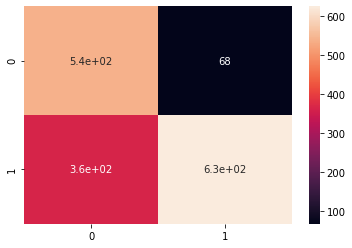

In [37]:
start = time.time()
corpus_train = porterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = naiveBayes(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Naïve Bayes with Snowball Stemmer

Accuracy:  0.725625
Precision:  0.9011627906976745
Recall:  0.6256306760847629
F1:  0.7385348421679573
Time: 53.67 seconds


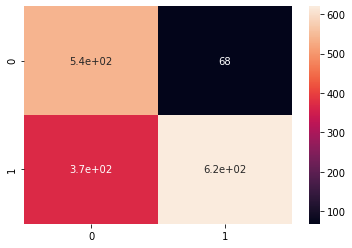

In [21]:
start = time.time()
corpus_train = snowballStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = naiveBayes(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Naïve Bayes with Lancaster Stemmer

Accuracy:  0.720625
Precision:  0.8930635838150289
Recall:  0.6236125126135217
F1:  0.7344028520499108
Time: 53.79 seconds


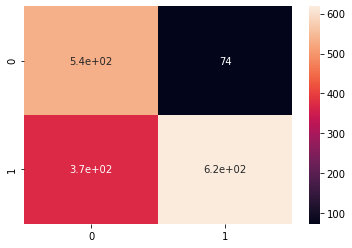

In [22]:
start = time.time()
corpus_train = lancasterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = naiveBayes(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Naïve Bayes with Lemmatization

Accuracy:  0.74875
Precision:  0.9039780521262003
Recall:  0.6649848637739657
F1:  0.766279069767442
Time: 52.45 seconds


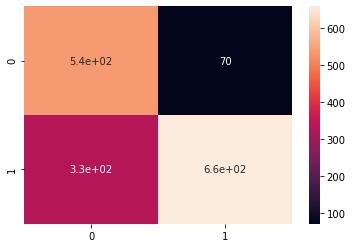

In [25]:
start = time.time()
corpus_train = lemmatization(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = naiveBayes(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Porter Stemmer

Accuracy:  0.820625
Precision:  0.8346007604562737
Recall:  0.8859737638748738
F1:  0.8595203132648067
Time: 102.40 seconds


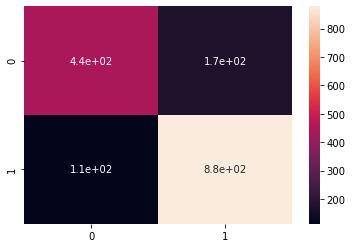

In [21]:
start = time.time()
corpus_train = porterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVM(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Snowball Stemmer

Accuracy:  0.81625
Precision:  0.8315889628924833
Recall:  0.8819374369323916
F1:  0.8560235063663076
Time: 149.23 seconds


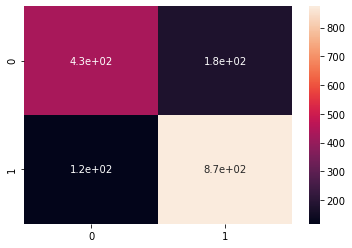

In [26]:
start = time.time()
corpus_train = snowballStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVM(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Lancaster Stemmer

Accuracy:  0.82
Precision:  0.8350810295519543
Recall:  0.8839556004036327
F1:  0.8588235294117647
Time: 171.04 seconds


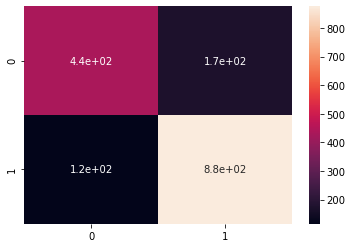

In [27]:
start = time.time()
corpus_train = lancasterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVM(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Lemmatization

Accuracy:  0.813125
Precision:  0.8203703703703704
Recall:  0.8940464177598385
F1:  0.8556253017865765
Time: 168.53 seconds


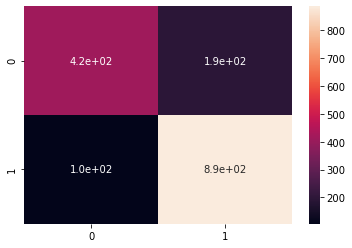

In [28]:
start = time.time()
corpus_train = lemmatization(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVM(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Decision Tree with Porter Stemmer

In [ ]:
start = time.time()
corpus_train = porterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = decisionTree(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Decision Tree with Snowball Stemmer

Accuracy:  0.715625
Precision:  0.7977777777777778
Recall:  0.7245206861755802
F1:  0.7593865679534636
Time: 72.51 seconds


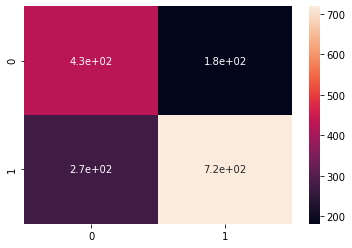

In [30]:
start = time.time()
corpus_train = snowballStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = decisionTree(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Decision Tree with Lancaster Stemmer

Accuracy:  0.690625
Precision:  0.7811791383219955
Recall:  0.6952573158425832
F1:  0.7357180993059264
Time: 75.71 seconds


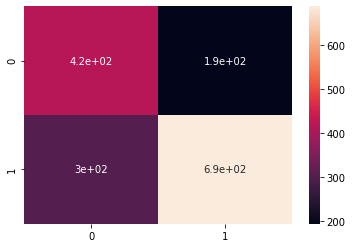

In [31]:
start = time.time()
corpus_train = lancasterStemming(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = decisionTree(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### Decision Tree with Lemmatization

Accuracy:  0.713125
Precision:  0.7910284463894968
Recall:  0.7295660948536832
F1:  0.7590551181102362
Time: 72.78 seconds


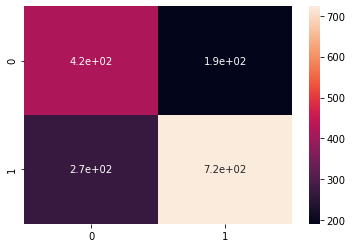

In [32]:
start = time.time()
corpus_train = lemmatization(trainC)
train_x, train_y = bagOfWords(corpus_train, trainC)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = decisionTree(X_train, y_train, X_test)
performance(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

### Solving "humor_rating"

#### SVM with Porter Stemming

In [113]:
start = time.time()
corpus_train = porterStemming(trainR)
train_x, train_y = bagOfWords(corpus_train, trainR)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVMRegression(X_train, y_train, X_test)
performanceRegression(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

Root mean squared error:  0.910262590823677
Time: 264.12 seconds


#### SVM with Snowball Stemming

In [ ]:
start = time.time()
corpus_train = snowballStemming(trainR)
train_x, train_y = bagOfWords(corpus_train, trainR)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVMRegression(X_train, y_train, X_test)
performanceRegression(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Lancaster Stemming

In [ ]:
start = time.time()
corpus_train = lancasterStemming(trainR)
train_x, train_y = bagOfWords(corpus_train, trainR)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVMRegression(X_train, y_train, X_test)
performanceRegression(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

#### SVM with Lemmatization

In [ ]:
start = time.time()
corpus_train = lemmatization(trainR)
train_x, train_y = bagOfWords(corpus_train, trainR)
X_train, X_test, y_train, y_test = dataSplit(train_x, train_y)
y_pred = SVMRegression(X_train, y_train, X_test)
performanceRegression(y_test, y_pred)
print("Time: %.2f seconds" % (time.time() - start))

## Conclusions

[[ go back to the top ]](#Table-of-contents)

### Accuracy

|   | Porter Stemming | Snowball Stemming | Lancaster Stemming | Lemmatization |
|---|:----:|:----:|:----:|:----:|
| **Naïve Bayes** | 0.729375 | 0.725625  | 0.720625  | 0.74875  |
| **SVM** | 0.820625  | 0.81625  | 0.82   | 0.813125  |
| **Decision Tree** |  0.71875 | 0.715625  | 0.690625  | 0.713125  |

### Precision
|   | Porter Stemming | Snowball Stemming | Lancaster Stemming | Lemmatization |
|---|:----:|:----:|:----:|:----:|
| **Naïve Bayes** | 0.9020172910662824  | 0.9011627906976745  | 0.8930635838150289  | 0.9039780521262003  |
| **SVM** | 0.8346007604562737 | 0.8315889628924833 | 0.8350810295519543  | 0.8203703703703704  |
| **Decision Tree** | 0.7982359426681367  | 0.7977777777777778  | 0.7811791383219955  | 0.7910284463894968  |

### Recall
|   | Porter Stemming | Snowball Stemming | Lancaster Stemming | Lemmatization |
|---|:----:|:----:|:----:|:----:|
| **Naïve Bayes** | 0.6316851664984864  | 0.6256306760847629  |  0.6236125126135217 | 0.6649848637739657  |
| **SVM** | 0.8859737638748738 | 0.8819374369323916 |  0.8839556004036327 | 0.8940464177598385  |
| **Decision Tree** | 0.7305751765893037  |  0.7245206861755802 | 0.6952573158425832  |  0.7295660948536832 |

### F1
|   | Porter Stemming | Snowball Stemming | Lancaster Stemming | Lemmatization |
|---|:----:|:----:|:----:|:----:|
| **Naïve Bayes** | 0.7430267062314541 |  0.7385348421679573 |  0.7344028520499108 | 0.766279069767442  |
| **SVM** | 0.8595203132648067 | 0.8560235063663076 | 0.8588235294117647  | 0.8556253017865765  |
| **Decision Tree** |  0.7629083245521602 | 0.7593865679534636  | 0.7357180993059264  |  0.7590551181102362 |

### Time
| **in seconds**  | Porter Stemming | Snowball Stemming | Lancaster Stemming | Lemmatization |
|---|:----:|:----:|:----:|:----:|
| **Naïve Bayes** | 51.89   | 53.67   | 53.79   |  52.45  |
| **SVM** | 156.88  | 149.23  | 171.04   | 168.53   |
| **Decision Tree** | 74.84   |  72.51  | 75.71   | 72.78   |


## References

[[ go back to the top ]](#Table-of-contents)

- https://competitions.codalab.org/competitions/27446
- https://en.wikipedia.org/wiki/Natural_language_processing
- https://moodle.up.pt/pluginfile.php/213489/mod_resource/content/1/IART_Lecture7_NaturalLanguageProcessing_2020_21.pdf
- https://moodle.up.pt/pluginfile.php/211544/mod_resource/content/0/IART_Lecture5a_Intro_MachineLearning.pdf
- https://moodle.up.pt/pluginfile.php/213487/mod_resource/content/0/IART_Lecture5d_MachineLearning_Classification.pdf